Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


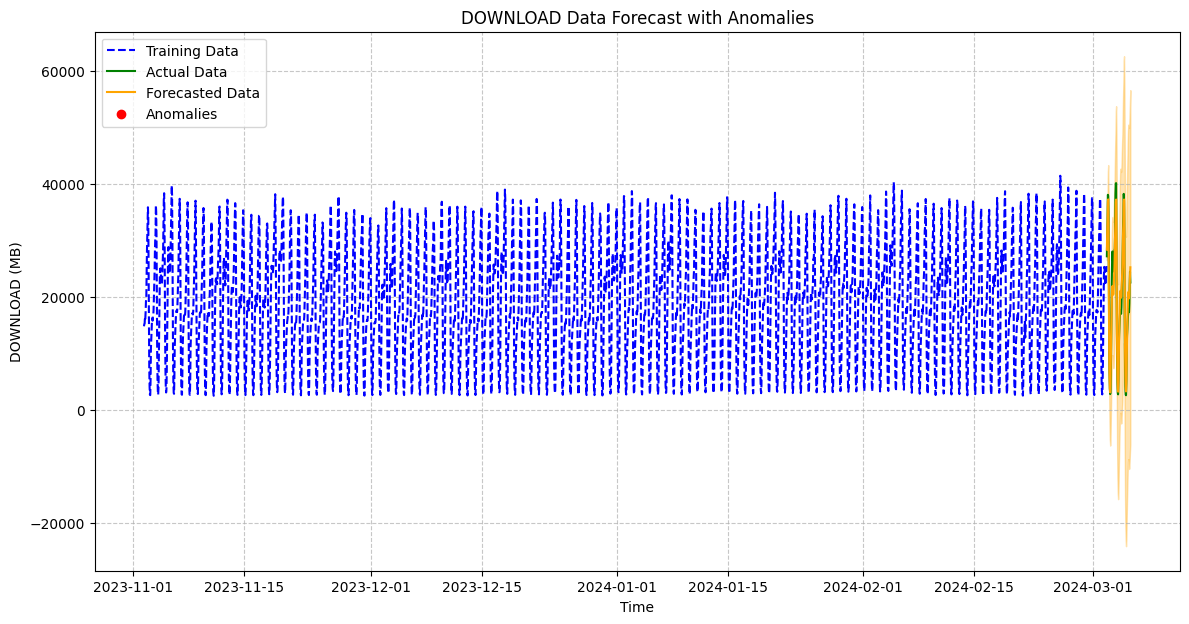

Empty DataFrame
Columns: [DOWNLOAD, UPLOAD]
Index: []


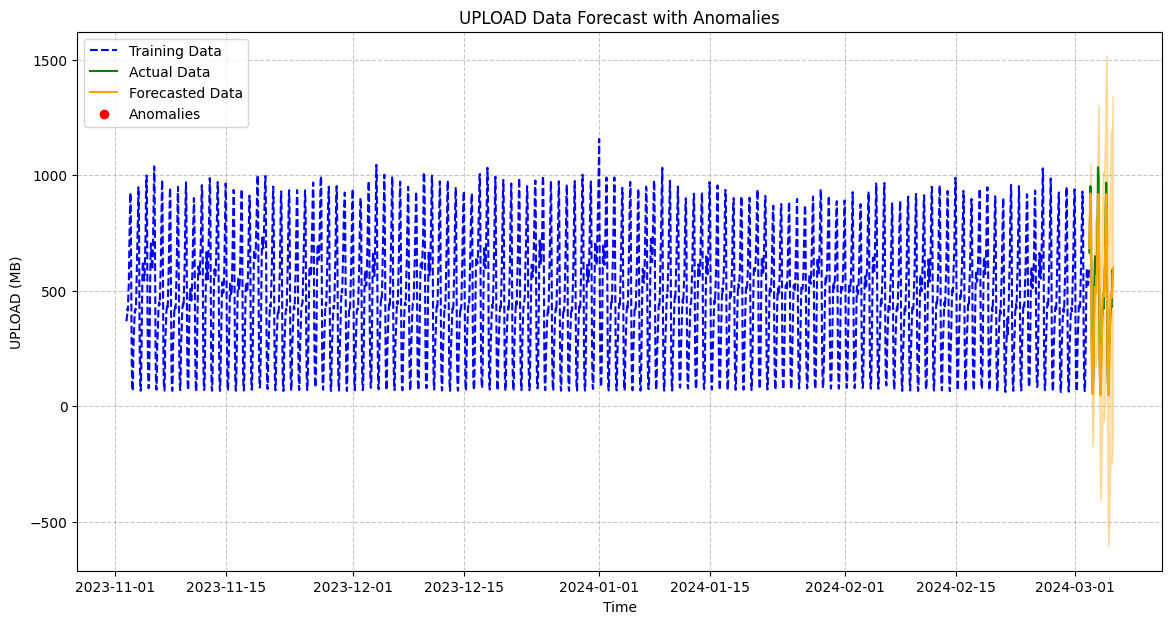

Empty DataFrame
Columns: [DOWNLOAD, UPLOAD]
Index: []


In [5]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/dataset.xlsx')

#date time index
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'])
df.set_index('TIME_STAMP', inplace=True)

# Dropping non numerical data
numeric_data = df.drop(columns=['SERVER_NAME'])

#hourly frequencyresambşe
data_resampled = numeric_data.resample('H').mean()

# Separate the data into training and testing sets
train_data = data_resampled.iloc[:-72]  # Use all but the last 72 hours for training
test_data = data_resampled.iloc[-72:]  # Use the last 72 hours for testing

#Fit SARIMA model and forecast
def fit_and_forecast(train, test, column_name):
    try:
        sarima_model = SARIMAX(train[column_name], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
        sarima_fit = sarima_model.fit(disp=False)
    except Exception as e:
        print(f"Error fitting SARIMA model for {column_name}: {e}")
        return None, None

    try:
        forecast = sarima_fit.get_forecast(steps=len(test))
        forecast_ci = forecast.conf_int(alpha=0.05)
        forecast_index = test.index[:len(test)]
        forecast_ci.index = forecast_index
        forecast.predicted_mean.index = forecast_index

        anomalies = test[(test[column_name] < forecast_ci.iloc[:, 0]) |
                         (test[column_name] > forecast_ci.iloc[:, 1])]

        return forecast, forecast_ci, anomalies
    except Exception as e:
        print(f"Error during forecasting or anomaly detection for {column_name}: {e}")
        return None, None, None

# Fit and forecast for DOWNLOAD
forecast_download, forecast_download_ci, anomalies_download = fit_and_forecast(train_data, test_data, 'DOWNLOAD')

# Fit and forecast for UPLOAD
forecast_upload, forecast_upload_ci, anomalies_upload = fit_and_forecast(train_data, test_data, 'UPLOAD')

def plot_forecast(train, test, forecast, forecast_ci, anomalies, column_name):
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train[column_name], label='Training Data', color='blue', linestyle='--')
    plt.plot(test.index, test[column_name], label='Actual Data', color='green')
    plt.plot(test.index, forecast.predicted_mean, label='Forecasted Data', color='orange')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
    plt.scatter(anomalies.index, anomalies[column_name], color='red', label='Anomalies')

    for index in anomalies.index:
        plt.axvspan(index, index + pd.Timedelta(hours=1), color='red', alpha=0.1)

    plt.title(f'{column_name} Data Forecast with Anomalies')
    plt.xlabel('Time')
    plt.ylabel(f'{column_name} (MB)')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(anomalies)

if forecast_download is not None:
    plot_forecast(train_data, test_data, forecast_download, forecast_download_ci, anomalies_download, 'DOWNLOAD')

if forecast_upload is not None:
    plot_forecast(train_data, test_data, forecast_upload, forecast_upload_ci, anomalies_upload, 'UPLOAD')
